# 2020 - Enhancing Credit Card Fraud Detection Using Deep Neural Network

В данном ноутбуке была проведена попытка вопроизвести результаты из статьи https://link.springer.com/chapter/10.1007/978-3-030-52246-9_21

In [1]:
import pandas as pd
import numpy as np

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

Авторы статьи не оставили ссылку на датасет, я нашел его на [Kaggle](https://www.kaggle.com/mlg-ulb/creditcardfraud) по описанию. 

In [2]:
df = pd.read_csv('creditcard.csv')
print('Баланс классов:\n', df['Class'].value_counts(), sep='')

Баланс классов:
0    284315
1       492
Name: Class, dtype: int64


In [3]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [4]:
X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values

In [5]:
# Разбиваем выборку на обучающую и тестовую
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.3)

In [6]:
# Отнормируем данные  
scaler = StandardScaler()

X_train_norm = scaler.fit_transform(X_train)
X_test_norm = scaler.transform(X_test)

Авторы статьи ничего не написали о том, сколько прошлых трансакций учитывается при классификации текущих трансакций. Поэтому я позаимствовал размер окна из работы [Sequence classification for credit-card fraud detection](https://www.sciencedirect.com/science/article/abs/pii/S0957417418300435).

In [7]:
window = 10

def generate_windows(X, y, window=10):    
    X_new = np.zeros(((X.shape[0]-window+1), window, X.shape[1]))
    y_new = y[window-1:]

    for i in range(X_new.shape[0]):
        X_new[i, :, :] = X[i:i+window, :]
    
    return X_new, y_new

X_train_w, y_train_w = generate_windows(X_train_norm, y_train, window)
X_test_w, y_test_w = generate_windows(X_test_norm, y_test, window)

In [8]:
train_set = TensorDataset(torch.tensor(X_train_w, dtype=torch.float32), torch.tensor(y_train_w, dtype=torch.float32))
test_set = TensorDataset(torch.tensor(X_test_w, dtype=torch.float32), torch.tensor(y_test_w, dtype=torch.float32))

train_loader = DataLoader(train_set, batch_size=128)
test_loader = DataLoader(test_set, batch_size=128)

В статье не указано число нейронов в последнем скрытом слое, поэтому я решил установить там такое же число нейронов, как в рекуррентном слое.

In [9]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.rnn = nn.LSTM(30, 12)
        self.fc1 = nn.Linear(12, 12)
        self.act = nn.Tanh()
        self.fc2 = nn.Linear(12, 1)

    def forward(self, x):
        _, (h, c) = self.rnn(x.permute(1, 0 ,2)) # h shape: 1 x batch size x LSTM hidden layer size
        x = self.fc1(h.squeeze(0))               # x shape: batch size x dense hidden layer size 
        x = self.act(x)
        logits = self.fc2(x).squeeze()           # logits shape: batch size x output size         
        return torch.sigmoid(logits)

Инициализирую веса таким же образом, как указано в статье.

In [10]:
model = Model()

def init_weights(m):
    for name, param in m.named_parameters():
        fan_in = param.shape[-1] # number of input units
        limit = np.sqrt(3/fan_in)
        nn.init.uniform_(param, -limit, limit)
        
model.apply(init_weights)

Model(
  (rnn): LSTM(30, 12)
  (fc1): Linear(in_features=12, out_features=12, bias=True)
  (act): Tanh()
  (fc2): Linear(in_features=12, out_features=1, bias=True)
)

Для обучения модели используем функцию потерь и оптимизатор, которые указаны в статье.

In [11]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
criterion = nn.MSELoss()
optimizer = torch.optim.RMSprop(model.parameters())

model.to(device)
h = []
epochs = 50
for i in tqdm(range(epochs)):
    epoch_loss = []
    for x_batch, y_batch in train_loader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()

        logits = model(x_batch)
        loss = criterion(logits, y_batch)

        loss.backward()
        optimizer.step()
        
        epoch_loss.append(loss.item())
        
    h.append(np.mean(epoch_loss))
    
model.to('cpu')

  0%|          | 0/50 [00:00<?, ?it/s]

Model(
  (rnn): LSTM(30, 12)
  (fc1): Linear(in_features=12, out_features=12, bias=True)
  (act): Tanh()
  (fc2): Linear(in_features=12, out_features=1, bias=True)
)

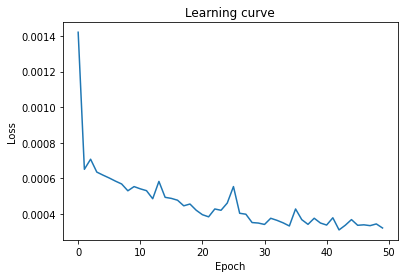

In [12]:
plt.plot(h)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Learning curve');

In [13]:
loaders = {'Train':train_loader,
           'Test': test_loader}
predictions = {}
true_labels = {}

with torch.no_grad():
    for key in loaders.keys():
        y_pred = np.array([])
        y_true = np.array([])
        for x_batch, y_batch in loaders[key]:
            preds = model(x_batch)
            y_pred = np.hstack((y_pred, preds.numpy()))
            y_true = np.hstack((y_true, y_batch.numpy()))
        
        predictions[key] = y_pred
        true_labels[key] = y_true

In [14]:
for key in predictions.keys():
    predicted_labels = predictions[key] >= 0.5
    accuracy = np.mean(predicted_labels == true_labels[key])
    print('{} accuracy: {:.6f}'.format(key, accuracy))

Train accuracy: 0.999629
Test accuracy: 0.999520


Авторы статьи выбрали метрику качества Accuracy. При этом, в статье не упомянута точка отсечения, поэтому я предполагаю, что авторами была использована точка отсечения `0.5`. У меня получились довольно близкие значения Accuracy. Учитывая то, что данный датасет очень не сбалансированный, я решил посмотреть на другую метрику качества (которая мне показалась более подходящей) - ROC-AUC. 

In [15]:
for key in predictions.keys():
    rocauc = roc_auc_score(true_labels[key], predictions[key])
    print('{} ROC-AUC: {:.6f}'.format(key, rocauc))

Train ROC-AUC: 0.943053
Test ROC-AUC: 0.892572


На основе значения метрики ROC-AUC можно сделать вывод о том, что модель, предложенная авторами данной статьи, вполне рабочая и хорошо справляется с задачей классфикации на несбалансированной выборке.